# Sampling from the autorregresive model

> We will be taken an already trained model and sample from it!

In [1]:
import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

2023-08-15 00:25:44.510042: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-15 00:25:44.567701: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 00:25:46.440089: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
from typing import Any, Callable, Sequence, Union
import numpy as np
import matplotlib.pyplot as plt

import jax
from jax import lax, random, numpy as jnp
from flax.core import freeze, unfreeze, FrozenDict
from flax import linen as nn
from flax import struct
from flax.training import train_state
from flax.training import orbax_utils

import optax
import orbax.checkpoint

from clu import metrics
from ml_collections import ConfigDict

from einops import reduce
import wandb

In [3]:
class PixelConv(nn.Module):
    """Masked convolution as in PixelCNN."""
    mask_type: str
    features: int
    kernel_size: Sequence[int]
    strides: int = 1
    padding: str = "SAME"
    use_bias: bool = True
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros_init()

    @nn.compact
    def __call__(self, inputs):
        ## 0. Instantiate the kernel and bias of the convolution
        kernel = self.param("kernel",
                            self.kernel_init,
                            (self.kernel_size[0], self.kernel_size[1], inputs.shape[-1], self.features))
        bias = self.param("bias",
                          self.bias_init,
                          (self.features,)) if self.use_bias else 0.

        ## 1. Build the mask
        mask = self.generate_mask(kernel.shape, self.mask_type)

        ## 2. Calculate the masked convolution
        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv(jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
               jnp.transpose(kernel*mask,[3,2,0,1]), # rhs = OIHW conv kernel tensor
               (self.strides, self.strides),
               self.padding)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        if not had_batch: outputs = outputs[0]
        return outputs + bias
    
    @staticmethod
    def generate_mask(kernel_size, mask_type):
        mask = jnp.zeros(shape=kernel_size)
        mask = mask.at[:kernel_size[0]//2].set(1.)
        mask = mask.at[kernel_size[0]//2,:kernel_size[1]//2].set(1.)
        if mask_type == "B":
            mask = mask.at[kernel_size[0]//2,kernel_size[1]//2].set(1.)
        return mask

In [4]:
class ResidualBlock(nn.Module):
    """Residual block based on the `PixelConv` layer."""
    mask_type: str
    features: int
    kernel_size: Sequence[int]
    strides: int = 1
    padding: str = "SAME"
    use_bias: bool = True
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros_init()

    @nn.compact
    def __call__(self, inputs):
        outputs = nn.Conv(self.features, kernel_size=(1,1))(inputs)
        outputs = nn.relu(outputs)
        outputs = PixelConv(features=self.features//2, kernel_size=self.kernel_size, mask_type=self.mask_type)(outputs)
        outputs = nn.relu(outputs)
        outputs = nn.Conv(self.features, kernel_size=(1,1))(outputs)
        outputs = nn.relu(outputs)
        return inputs + outputs

In [5]:
class PixelCNN(nn.Module):
    """PixelCNN model as stated in their original paper (or so they said in the Keras example)."""

    n_residual_blocks: int = 5

    @nn.compact
    def __call__(self, inputs):
        outputs = PixelConv(features=128, kernel_size=(7,7), mask_type="A")(inputs)
        outputs = nn.relu(outputs)
        for _ in range(self.n_residual_blocks):
            outputs = ResidualBlock(features=128, kernel_size=(3,3), mask_type="B")(outputs)
            outputs = nn.relu(outputs)
        outputs = PixelConv(features=128, kernel_size=(1,1), mask_type="B")(outputs)
        outputs = nn.relu(outputs)
        outputs = PixelConv(features=128, kernel_size=(1,1), mask_type="B")(outputs)
        outputs = nn.relu(outputs)
        outputs = nn.Conv(features=1, kernel_size=(1,1))(outputs)
        ## Skip the sigmoid activation because it's included in the loss function we will be using
        return outputs

In [6]:
@struct.dataclass
class Metrics(metrics.Collection):
    """Collection of metrics to be tracked during training."""
    loss: metrics.Average.from_output("loss")

In [7]:
class TrainState(train_state.TrainState):
    metrics: Metrics

In [8]:
def create_train_state(module, key, tx, input_shape):
    """Creates the initial `TrainState`."""
    params = module.init(key, jnp.ones(input_shape))["params"]
    return TrainState.create(
        apply_fn=module.apply,
        params=params,
        tx=tx,
        metrics=Metrics.empty()
    )

In [9]:
state = create_train_state(PixelCNN(), random.PRNGKey(0), optax.adam(3e-4), input_shape=(1,28,28,1))

In [10]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(state)

## Now we'll load the pretrained model

In [11]:
state = orbax_checkpointer.restore("model-final-1000", item=state)

In [12]:
@jax.jit
def obtain_pred(state, inputs): 
    return state.apply_fn({"params": state.params}, inputs)

In [29]:
%%time
keygen = random.PRNGKey(0)
n_imgs_to_generate = 4
generated_batch = jnp.zeros(shape=(n_imgs_to_generate,28,28,1))
batch, rows, cols, channels = generated_batch.shape

for row in range(rows):
    for col in range(cols):
        for channel in range(channels):
            ## 1. Pass the blank images to generate the next (or first) pixel
            pred = obtain_pred(state, generated_batch)
            pred = nn.sigmoid(pred)
            ## 2. Obtain the value of the pixel by sampling from a Bernoulli distribution
            pixel = pred[:,row,col,channel]
            pixel = random.bernoulli(keygen, p=pixel)*1.
            keygen, _ = random.split(keygen)
            generated_batch = generated_batch.at[:,row,col,channel].set(pixel)
    #         break
    #     break
    # break

CPU times: user 13.4 s, sys: 3.42 s, total: 16.9 s
Wall time: 8.84 s


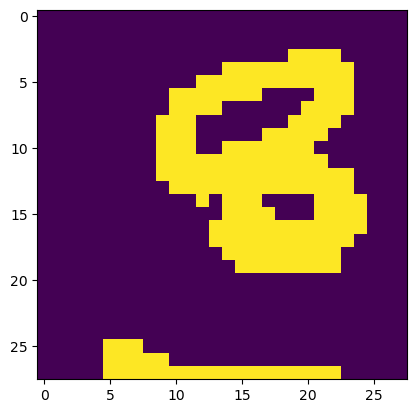

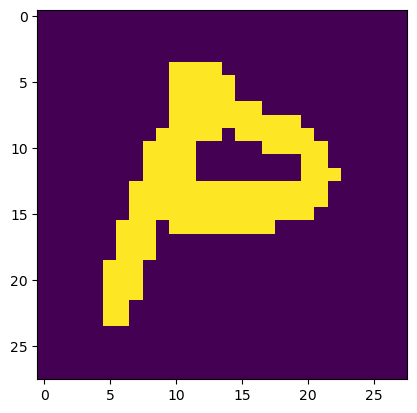

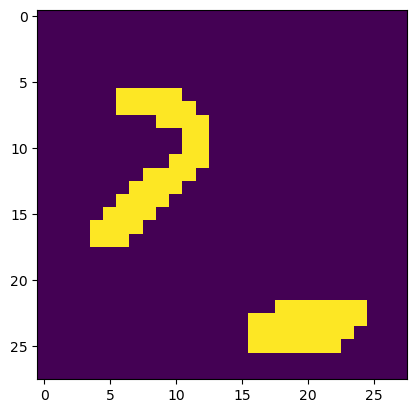

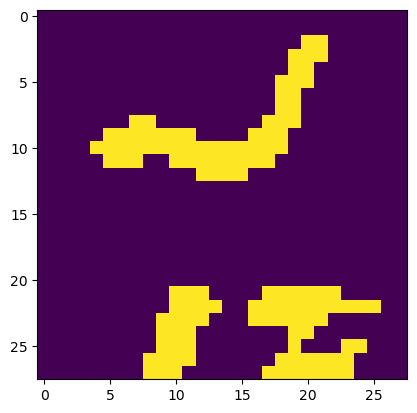

In [30]:
for gen_img in generated_batch:
    plt.imshow(gen_img)
    plt.show()